In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from wbfm.utils.projects.finished_project_data import ProjectData
import napari
import pandas as pd
import numpy as np
from wbfm.utils.feature_detection.class_frame_pair import FramePair



Bad key "text.kerning_factor" on line 4 in
/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
fname = "/scratch/zimmer/Charles/dlc_stacks/worm9-gui_test/project_config.yaml"
project_data = ProjectData.load_final_project_data_from_config(fname, to_load_tracklets=True, to_load_segmentation_metadata=True)

Output files: /scratch/zimmer/Charles/dlc_stacks/worm9-gui_test/3-tracking/manual_annotation/global2tracklet_manual.pickle, /scratch/zimmer/Charles/dlc_stacks/worm9-gui_test/3-tracking/manual_annotation/manually_split_tracklets.h5, /scratch/zimmer/Charles/dlc_stacks/worm9-gui_test/3-tracking/manual_annotation/split_names.pickle, /scratch/zimmer/Charles/dlc_stacks/worm9-gui_test/3-tracking/manual_annotation/split_times.pickle
Project data for directory:
/scratch/zimmer/Charles/dlc_stacks/worm9-gui_test 
Found the following raw data files:
red_data:                 True
green_data:               True
============Segmentation===============
raw_segmentation:         True
segmentation:             True
============Tracklets==================
df_training_tracklets:    True
reindexed_masks_training: True
============Traces=====================
red_traces:               True
green_traces:             True
final_tracks:             True
behavior_annotations:     True



# Look at tracklets that were correctly and incorrectly assigned

In [3]:
df_tracklets = project_data.df_all_tracklets

In [4]:
# Neuron 2
i_was_assigned_good = 'tracklet_0000076'
was_assigned_good = df_tracklets[i_was_assigned_good]
i_was_assigned_bad = 'tracklet_0003725'
was_assigned_bad = df_tracklets[i_was_assigned_bad]

In [5]:
i_not_assigned_good = 'tracklet_0003411'
not_assigned_good = df_tracklets[i_not_assigned_good]

In [23]:
was_assigned_good.head()

coords,z,x,y,likelihood,raw_neuron_id,brightness_red,volume
0,10.422511,223.389691,563.542558,0.600999,81.0,14686.0,577.0
1,10.503183,221.308208,556.427538,0.728719,78.0,14925.0,562.0
2,10.520984,210.890190,531.396608,0.608017,80.0,15035.0,563.0
3,10.584052,211.489506,516.604448,0.504838,79.0,15199.0,576.0
4,10.943973,218.568154,500.607507,0.522517,82.0,16492.0,609.0


In [26]:
to_plot = 'brightness_red'

x1 = was_assigned_good[to_plot]
x2 = not_assigned_good[to_plot]
y1 = was_assigned_bad[to_plot]

([array([ 1.,  5., 15., 62., 75., 74., 74., 53., 19.,  4.]),
  array([ 2.,  4., 21., 74., 86., 90., 37., 26., 12.,  5.]),
  array([ 0.,  5., 18., 24., 17.,  5.,  4.,  2.,  3.,  1.])],
 array([ 8155. , 10104.6, 12054.2, 14003.8, 15953.4, 17903. , 19852.6,
        21802.2, 23751.8, 25701.4, 27651. ]),
 <a list of 3 Lists of Patches objects>)

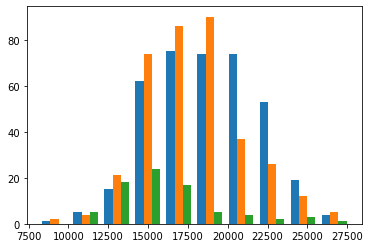

In [27]:
plt.hist([x1, x2, y1])

# Try simple outlier detection

In [33]:
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
# from sklearn.linear_model import SGDOneClassSVM

In [45]:
to_plot = ['brightness_red', 'z', 'volume']

# x1 = was_assigned_good[to_plot].dropna().to_numpy().reshape(-1,1)
# x2 = not_assigned_good[to_plot].dropna().to_numpy().reshape(-1,1)
# y1 = was_assigned_bad[to_plot].dropna().to_numpy().reshape(-1,1)
x1 = was_assigned_good[to_plot].dropna().to_numpy()
x2 = not_assigned_good[to_plot].dropna().to_numpy()
y1 = was_assigned_bad[to_plot].dropna().to_numpy()

In [46]:
x1.shape

(382, 3)

In [51]:
%%timeit
classifier = EllipticEnvelope(support_fraction=1.0, contamination=0.05).fit(x1)
classifier.predict(y1)

37.7 ms ± 9.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [52]:
%%timeit
classifier = OneClassSVM().fit(x1)
classifier.predict(y1)

9.91 ms ± 1.65 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [53]:
classifier.predict(y1)

array([-1, -1,  1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1,
        1,  1,  1,  1,  1,  1,  1,  1, -1,  1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1,  1, -1, -1, -1,  1, -1])

In [117]:
np.mean(classifier.predict(y1))

[autoreload of wbfm.utils.pipeline.tracklet_class failed: Traceback (most recent call last):
  File "/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/home/charles/anaconda3/envs/torch/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/charles/anaconda3/envs/torch/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap_external>", line 860, in get_code
  File "<frozen importlib._bootstrap_external>", line 791, in source_to_code
  File "<frozen importlib._bootstrap>",

-0.4430379746835443

# Use classes (initialize on training data)

# Scratch: Use neuron/tracklet classes

In [104]:
from wbfm.utils.pipeline.tracklet_class import TrackedWorm

In [105]:
tracklets_and_neurons_class = project_data.tracklets_and_neurons_class

worm_obj = TrackedWorm(detections=tracklets_and_neurons_class, verbose=1)

In [106]:
worm_obj.initialize_neurons_at_time_0()

In [107]:
worm_obj.global_name_to_neuron['neuron_001']

Neuron neuron_001 (index=0) with 1 tracklets from time 0 to 373

In [108]:
tracklets_and_neurons_class.df_tracklets_zxy['tracklet_0000000']

coords,z,x,y,likelihood,raw_neuron_id,brightness_red,volume
0,4.152485,275.693147,552.621238,0.542036,1.0,30803.0,800.0
1,3.468167,274.280342,556.839252,0.760970,5.0,31540.0,781.0
2,3.360745,263.394089,552.938977,0.436579,4.0,29841.0,753.0
3,3.284924,258.567386,545.282091,0.471898,6.0,29650.0,776.0
4,3.493030,258.036256,540.754655,0.389865,4.0,29485.0,752.0
...,...,...,...,...,...,...,...
1994,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [109]:
neuron = worm_obj.global_name_to_neuron['neuron_001']

In [110]:
neuron.neuron2tracklets.nodes(data=True)

NodeDataView({'bipartite_0_frame_0_neuron_001': {'bipartite': 0, 'group_ind': 0, 'local_ind': 0, 'metadata': 'neuron_001'}, 'bipartite_1_trackletGroup_1_tracklet_0000000': {'bipartite': 1, 'group_ind': 0, 'local_ind': 0, 'metadata': 'tracklet_0000000'}})

In [115]:
worm_obj.get_tracklets_for_neuron('neuron_001')

[coords         z           x           y  likelihood  raw_neuron_id  \
 0       4.152485  275.693147  552.621238    0.542036            1.0   
 1       3.468167  274.280342  556.839252    0.760970            5.0   
 2       3.360745  263.394089  552.938977    0.436579            4.0   
 3       3.284924  258.567386  545.282091    0.471898            6.0   
 4       3.493030  258.036256  540.754655    0.389865            4.0   
 ...          ...         ...         ...         ...            ...   
 1994         NaN         NaN         NaN         NaN            NaN   
 1995         NaN         NaN         NaN         NaN            NaN   
 1996         NaN         NaN         NaN         NaN            NaN   
 1997         NaN         NaN         NaN         NaN            NaN   
 1998         NaN         NaN         NaN         NaN            NaN   
 
 coords  brightness_red  volume  
 0              30803.0   800.0  
 1              31540.0   781.0  
 2              29841.0   753.0 

In [118]:
fname = "/scratch/zimmer/Charles/dlc_stacks/worm9-gui_test/2-training_data/training_data_tracks.h5"
df = pd.read_hdf(fname)

[autoreload of wbfm.utils.pipeline.tracklet_class failed: Traceback (most recent call last):
  File "/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/IPython/extens

In [122]:
df.columns.levels[0]

Index(['tracklet_0004291', 'tracklet_0005884', 'tracklet_0006008',
       'tracklet_0006367', 'tracklet_0006408', 'tracklet_0007044',
       'tracklet_0007709', 'tracklet_0008595', 'tracklet_0008757',
       'tracklet_0008948',
       ...
       'tracklet_0011687', 'tracklet_0011688', 'tracklet_0011691',
       'tracklet_0011695', 'tracklet_0011703', 'tracklet_0011707',
       'tracklet_0011710', 'tracklet_0011713', 'tracklet_0011715',
       'tracklet_0011722'],
      dtype='object', length=134)

([array([  0.,   0.,   0.,   0.,   1., 133.,   0.,   0.,   0.,   0.]),
  array([ 3.,  5., 10., 25., 44., 24., 11.,  5.,  2.,  5.]),
  array([ 0.,  0.,  0.,  2., 41., 84.,  2.,  2.,  0.,  3.])],
 array([-28.68407182, -23.22271242, -17.76135303, -12.29999363,
         -6.83863423,  -1.37727484,   4.08408456,   9.54544396,
         15.00680336,  20.46816275,  25.92952215]),
 <a list of 3 Lists of Patches objects>)

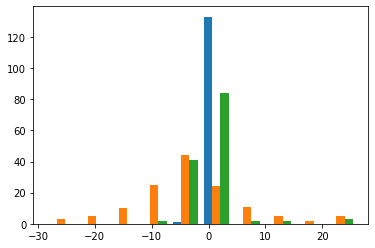

In [146]:
plt.hist((project_data.get_centroids_as_numpy_training(1) - project_data.get_centroids_as_numpy_training(2)))

In [143]:
from wbfm.utils.external.utils_pandas import dataframe_to_standard_zxy_format
df = project_data.df_training_tracklets
out = []
for i in range(5):
    out.append(dataframe_to_standard_zxy_format(df).iloc[i, :].to_numpy().reshape(-1, 3))
out[0][:5]

array([[  5.34002019, 266.14151737, 566.78110018],
       [ 11.70637777, 226.22800704, 601.02273945],
       [ 13.65441968, 267.22377658, 461.03264156],
       [ 10.13397175, 269.66573433, 484.54105433],
       [ 17.98593952, 318.14172256, 532.50123544]])

In [148]:
out[1][:5]

array([[  5.41329912, 267.66726534, 568.11084028],
       [ 12.03034551, 228.7489074 , 605.02861384],
       [ 14.03399187, 261.50116212, 466.44718187],
       [ 10.39362265, 265.97018612, 488.0521743 ],
       [ 17.96163711, 318.83612133, 531.42293967]])

In [141]:
project_data.get_centroids_as_numpy_training(0)[:5]

array([[  5.34002019, 266.14151737, 566.78110018],
       [ 11.70637777, 226.22800704, 601.02273945],
       [ 13.65441968, 267.22377658, 461.03264156],
       [ 10.13397175, 269.66573433, 484.54105433],
       [ 17.98593952, 318.14172256, 532.50123544]])

([array([  0.,   0.,   0.,   0.,   1., 133.,   0.,   0.,   0.,   0.]),
  array([ 3.,  5., 10., 25., 44., 24., 11.,  5.,  2.,  5.]),
  array([ 0.,  0.,  0.,  2., 41., 84.,  2.,  2.,  0.,  3.])],
 array([-28.68407182, -23.22271242, -17.76135303, -12.29999363,
         -6.83863423,  -1.37727484,   4.08408456,   9.54544396,
         15.00680336,  20.46816275,  25.92952215]),
 <a list of 3 Lists of Patches objects>)

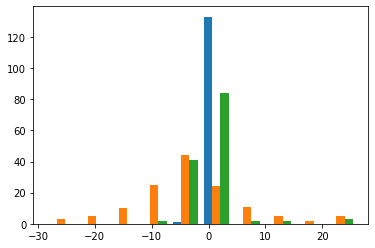

In [147]:
plt.hist(out[1] - out[2])

In [152]:
zxy = project_data.get_centroids_as_numpy(1000)
phys = project_data.project_config.get_physical_unit_conversion_class()

In [153]:
phys.zimmer2leifer(zxy)

array([[-4.49640128e-01,  3.33181640e-01, -9.95331457e-02],
       [ 2.34404112e-01, -2.33234483e-01, -1.25965810e-01],
       [ 2.90584616e-01, -4.00393036e-01, -9.63465270e-02],
       [-2.86950330e-01,  2.37742353e-01, -9.08058528e-02],
       [-1.01216600e-01,  1.49144515e-01, -1.16194639e-01],
       [-4.37927765e-02,  3.34311188e-02, -1.01882913e-01],
       [-1.71536345e-01,  2.31330445e-01, -8.11370589e-02],
       [-3.37825549e-01,  2.86630986e-01, -9.28439268e-02],
       [ 4.11493929e-02, -5.26924838e-02, -1.13688017e-01],
       [-9.33847096e-03, -2.15767978e-02, -1.05785373e-01],
       [ 7.26277333e-02, -1.99360457e-02, -9.27530530e-02],
       [ 2.01930246e-01, -1.26146697e-01, -1.14760633e-01],
       [-2.55558999e-01,  2.02865834e-01, -8.72180622e-02],
       [ 1.22091156e-01,  1.45960050e-02, -7.06548265e-02],
       [ 1.31734484e-01, -3.72415769e-02, -8.58042866e-02],
       [-3.18331606e-01,  2.06035105e-01, -9.19302747e-02],
       [-1.46860153e-01,  1.23448716e-02